Inspiration from [this notebook](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove) 

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

In [61]:
input_dir = "/kaggle/input/nlp-getting-started"
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df=pd.concat([train,test])

### Collect some key metrics:

Lets compute the following metrics for the training dataset, to get a global view of the dataset

* Number of samples: Total number of examples 
* Number of samples per class: Number of samples per class (rean disaster /non real disaster).
* Number of words per sample: Median or mean number of words in one sample.
* Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
* Distribution of sample length: Distribution showing the number of words per sample in the dataset.

((( source https://developers.google.com/machine-learning/guides/text-classification/step-2)))

In [62]:
key_metrics= {'samples' : len(train),
             'samples_per_class' : train['target'].value_counts().median(),
             'median_of_samples_lengths': np.median(train['text'].str.split().map(lambda x: len(x))),
             }
key_metrics = pd.DataFrame.from_dict(key_metrics, orient='index').reset_index()
key_metrics.columns = ['metric', 'value']
key_metrics

,metric,value
0,samples,7613.0
1,samples_per_class,3806.5
2,median_of_samples_lengths,15.0


Some plots are always more comprehensive than numbers, so lets visulize and discover some useful insights
### Target class distribution with a bar plot

G:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

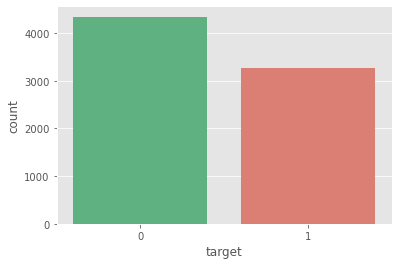

In [63]:
green = '#52BE80'
red = '#EC7063'
sns.countplot(train['target'], palette=[green, red])
# PS : here: https://htmlcolorcodes.com/fr/tableau-de-couleur/ => to a cheerful color table where you can get an infinity of color codes  

In [64]:
blue = "#5DADE2"
def get_sentences_len_histogram(fig_size = (10,6), _class=None, color=blue):
    """make histogram of lengths of the tweets
    * _class : consider all the dataset
    - _class=0 only non disaster tweets
    - _class=1 only disaster tweets"""
    f, ax = plt.subplots(figsize=fig_size)
    if str(_class)=='None':
        tweets_len=train['text'].str.len()
        ax.set_title('tweets length')
        ax.hist(tweets_len,color=color)
    else: 
        tweets_len=train[train['target']==_class]['text'].str.len()
        ax.set_title(f'{_class} disaster tweets length ')
        ax.hist(tweets_len,color=color)

    return ax

def get_words_count_histogram(fig_size = (10,6), _class=None, color=blue):
    """make histogram of lengths of the tweets
    * _class : consider all the dataset
    - _class=0 only non disaster tweets
    - _class=1 only disaster tweets"""
    f, ax = plt.subplots(figsize=fig_size)
    if str(_class)=='None':
        tweets_len=train['text'].str.split().map(lambda x: len(x))
        ax.set_title('words counts by tweet')
        ax.hist(tweets_len,color=color)
    else: 
        tweets_len=train[train['target']==_class]['text'].str.split().map(lambda x: len(x))
        ax.set_title(f'words counts by  "{_class}" disaster tweets ')
        ax.hist(tweets_len,color=color)

    return ax

### Histogram of text sentences lengths: 
#### a. in all the dataset

<AxesSubplot:title={'center':'tweets length'}>

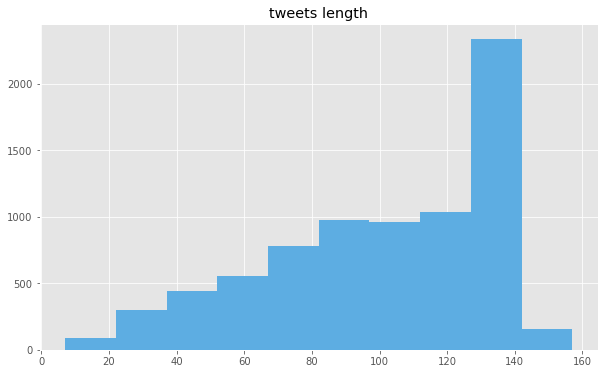

In [65]:
get_sentences_len_histogram()

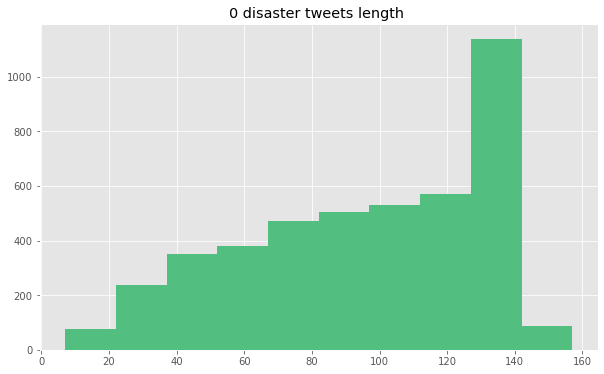

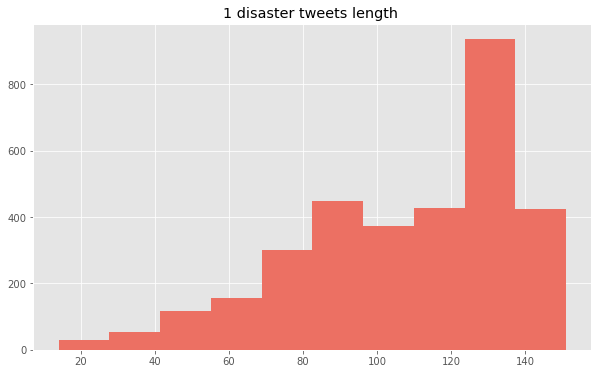

In [66]:
# two subplots
ax1 = get_sentences_len_histogram(_class=0, color=green)
ax1 = get_sentences_len_histogram(_class=1, color=red)

The Distribution of samples length is mainly concentrated between 120 to 140 characters

### Histogram of number of words for each tweet: 
#### a. in all the dataset


<AxesSubplot:title={'center':'words counts by tweet'}>

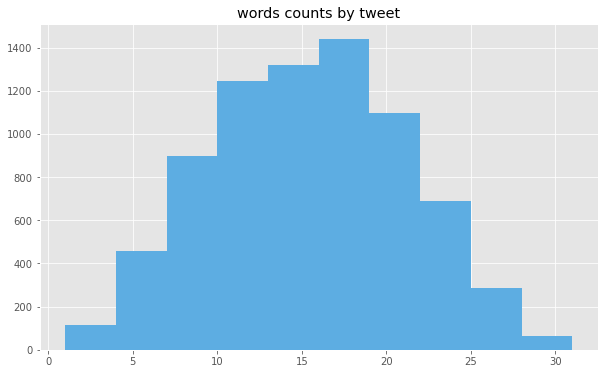

In [67]:
get_words_count_histogram()

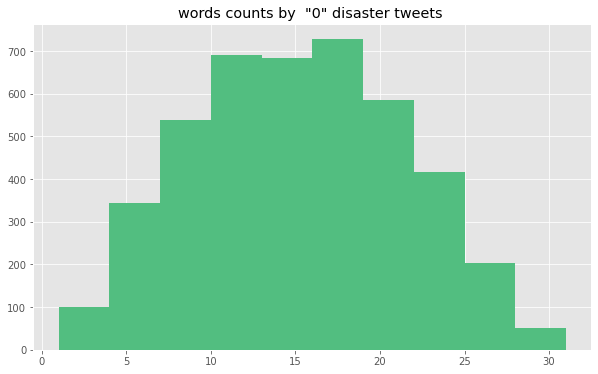

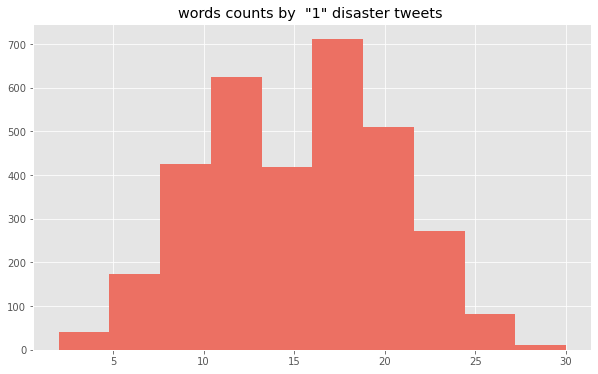

In [68]:
# two subplots
ax1 = get_words_count_histogram(_class=0, color=green)
ax1 = get_words_count_histogram(_class=1, color=red)

## Text cleaning:

we can apply some basic data cleaning that are recurrent in tweeters such as removing punctuation, html tags urls and emojis, spelling correction,..

In [69]:
from string import digits 

def tweets_cleaning(x, remove_emojis=True, remove_stop_words=True):
    """Apply function to a """
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # remove punctuation
    operator = str.maketrans('','',string.punctuation) #????
    x = x.translate(operator)
    # remove digits
    remove_digits = str.maketrans('', '', digits) 
    x = ' '.join([i.translate(remove_digits) for i in x.split()])
    
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        x = ' '.join([word for word in x.split(' ') if word not in stop])
    return x

In [70]:
df['cleaned_tweets'] = df['text'].apply(tweets_cleaning)

In [71]:
df

,id,keyword,location,text,target,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,earthquake safety los angeles safety fastener...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,storm ri worse last hurricane cityampothers ha...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,meg issues hazardous weather outlook hwo


In [72]:
train = df[~df['target'].isna()]
train['target'] = list(train['target'].astype(int))
test = df[df['target'].isna()]

<ipython-input-72-de70b1d2b7a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = list(train['target'].astype(int))


### train validation test split:

In [73]:
# lets keep a part a validation subset that will be used by our model
X_train, X_val, y_train, y_val = train_test_split(train, train['target'], test_size=0.2, random_state=42)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (6090, 6)
Shape of Validation  (1523, 6)


## Text pre-processing

1. Tokenization 
It consists in dividing the texts into words or smaller sub-texts, allowing us to determine the "vocabulary" of the dataset (set of unique tokens present in the data). Usually we use word-level representation. For our exemple we will use NLTK Tokenizer()
2. Word indexing:
Construct a vocablary_index mapper based on word frequency: the index would be inversely proportional to the word occurrence frequency in the overall dataset. the most frequent world would have index=1.. And every single word would get a unique


In [74]:
from keras.preprocessing import sequence
from keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 50

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, tweets):
        # Vectorize training and validation texts.
        
        tweets = self.tokenizer.texts_to_sequences(tweets)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        tweets = sequence.pad_sequences(tweets, maxlen=self.max_length, truncating='post',padding='post')
        return tweets
    
tokenizer = CustomTokenizer(train_texts = X_train['cleaned_tweets'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(X_train['cleaned_tweets'])
tokenized_val = tokenizer.vectorize_input(X_val['cleaned_tweets'])
tokenized_test = tokenizer.vectorize_input(test['cleaned_tweets'])

In [75]:
X_train['cleaned_tweets']

4996    courageous honest analysis need use atomic bom...
3263    zachzaidman thescore wld b shame golf cart bec...
4907    tell barackobama rescind medals honor given us...
2855    worried ca drought might affect extreme weathe...
4716    youngheroesid lava blast amp power red panther...
                              ...                        
5226    eganator arent many obliteration servers alway...
5390    panic attack bc dont enough money drugs alcoho...
860     omron hemc automatic blood pressure monitor st...
7603    officials say quarantine place alabama home po...
7270    moved england five years ago today whirlwind time
Name: cleaned_tweets, Length: 6090, dtype: object

In [76]:
tokenized_train

array([[ 5424,  3591,  2210, ...,     0,     0,     0],
       [ 5425,  5426,  5427, ...,     0,     0,     0],
       [  482,  2746,  5429, ...,     0,     0,     0],
       ...,
       [14575, 14576,  1578, ...,     0,     0,     0],
       [  456,    60,   396, ...,     0,     0,     0],
       [ 1872,  1550,  1037, ...,     0,     0,     0]])

In [77]:
tokenized_train.shape

(6090, 50)

In [78]:
tokenized_val.shape

(1523, 50)

In [79]:
tokenized_test.shape

(3263, 50)

In [80]:
tokenizer.vectorize_input(["In supervised learning, each data point is labeled or associated with a category or value of interest."])

array([[2091,  519,  741, 1804, 4288, 3297,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])

## Construct an embedding Matrix 🧱
First of we will download Glove pre-trained embedding from the official site:

In [81]:
import tqdm
'''import requests
import zipfile
URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"



def fetch_data(url=URL, target_file='glove.zip', delete_zip=False):
    #if the dataset already exists exit
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
        return

    #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall()
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)
        
fetch_data()'''

'import requests\nimport zipfile\nURL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"\n\n\n\ndef fetch_data(url=URL, target_file=\'glove.zip\', delete_zip=False):\n    #if the dataset already exists exit\n    if os.path.isfile(target_file):\n        print("datasets already downloded :) ")\n        return\n\n    #download (large) zip file\n    #for large https request on stream mode to avoid out of memory issues\n    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html\n    print("**************************")\n    print("  Downloading zip file")\n    print("  >_<  Please wait >_< ")\n    print("**************************")\n    response = requests.get(url, stream=True)\n    #read chunk by chunk\n    handle = open(target_file, "wb")\n    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):\n        if chunk:  \n            handle.write(chunk)\n    handle.close()  \n    print("  Download completed ;) :") \n    #extract

Then we will create an embedding matrix we will map each word index to its corresponding embedding vector:

In [82]:
glove_file = "G:\spark_big_files\glove.42B\glove.42B.300d.txt"


EMBEDDING_VECTOR_LENGTH = 50 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'rb') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix

embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.tokenizer.word_index)
print(embedding_matrix.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14579/14579 [00:00<00:00, 540761.40it/s]

(14580, 50)


In addition to the accuracy, we will add the precision, recall and F1-score as backend metrics to binary Keras Classifier model: we have to calculate them manually, because these metrics are not supported by keras since 2.0 version.

In [83]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Lets create the model

In [84]:
model=Sequential()
optimzer=Adam(clipvalue=0.5)

embedding=Embedding(len(tokenizer.tokenizer.word_index)+1, EMBEDDING_VECTOR_LENGTH, embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_SEQUENCE_LENGTH, trainable=False)

model.add(embedding)
model.add(Dropout(0.2))
#model.add(Dense(30, activation='relu'))#, kernel_constraint=maxnorm(3)))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer=optimzer, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

### fit the model

In [85]:
history=model.fit(tokenized_train,y_train, 
                  batch_size=32, epochs=20, 
                  validation_data=(tokenized_val,y_val), 
                  verbose=2)

Epoch 1/20
191/191 - 18s - loss: 0.6860 - acc: 0.5677 - f1_m: 0.0299 - precision_m: 0.0225 - recall_m: 0.0462 - val_loss: 0.6823 - val_acc: 0.5739 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 18s/epoch - 94ms/step
Epoch 2/20
191/191 - 5s - loss: 0.6837 - acc: 0.5695 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6822 - val_acc: 0.5739 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 5s/epoch - 25ms/step
Epoch 3/20
191/191 - 5s - loss: 0.6838 - acc: 0.5695 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6823 - val_acc: 0.5739 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 5s/epoch - 26ms/step
Epoch 4/20
191/191 - 5s - loss: 0.6836 - acc: 0.5695 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6822 - val_acc: 0.5739 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 


### Model evaluation

In [86]:

loss, accuracy, f1_score, precision, recall = model.evaluate(tokenized_val, y_val, verbose=0)

In [87]:
print(f'F1 score : {"%.3f"%f1_score}')
print(f'precision : {"%.3f"%precision}')
print(f'Recall : {"%.3f"%recall}')

F1 score : 0.000
precision : 0.000
Recall : 0.000


### Make new predictions:

In [88]:
# generate scores
test['scores'] = model.predict(tokenized_test)
# generate deisions
test['predction'] = list(np.round(test['scores']).astype(int))
test = test.drop('target', axis=1)

<ipython-input-88-b815e98be0d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['scores'] = model.predict(tokenized_test)
<ipython-input-88-b815e98be0d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predction'] = list(np.round(test['scores']).astype(int))


In [89]:
test.head()

,id,keyword,location,text,cleaned_tweets,scores,predction
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,0.425578,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,0.425578,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,0.425578,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,0.425578,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,0.425578,0


In [90]:
test['predction'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0
1       0
2       0
3       0
4       0
       ..
3258    0
3259    0
3260    0
3261    0
3262    0
Name: predction, Length: 3263, dtype: int64>